# Two electrons on a ring

## a)

Normalization:
$$
\displaystyle \int_0^{2\pi} \int_0^{2\pi} \Psi(x_1,x_2) \mathrm{d}x_1 \mathrm{d}x_2 = 1 \\
$$

Periodicity:
$$
\Psi(x_1,x_2) = \Psi(x_1+n\pi, x_2+m\pi), \quad n, m \in \mathbb{Z} \\
$$

Antisymmetry:
$$
\Psi(x_1, x_2) = -\Psi(x_2, x_1)
$$

Continuity (?)

## b)
In case of weak interaction, wavefunctions will be "smeared" across the ring, which will minimize the kinetic energy term.

With a large interaction constant, wavefunctions will be more localized, maximizing average distance between electrons.

## c)
$$
(H\Psi)_{i,j} =
    -\frac{1}{2w}(
        (\Psi_{i-1,j} - 2\Psi_{i,j} + \Psi_{i+1,j})
        +
        (\Psi_{i,j-1} - 2\Psi_{i,j} + \Psi_{i,j+1})
    )
    +
    \frac{1}{2}V(w(i-j))
$$

where $w$ is the discretization step

## d-e)

### Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### Hamiltonian etc

In [6]:
N = 400  # spatial resolution
dx = 2 * np.pi / N  # discretization step
eps = 1e-5  # division in potential function


def normalize(psi):
    norm = np.sqrt((psi * psi).sum())
    return psi / norm


def get_V(k, dx, N, eps):
    # k/2sqrt(2-2cos(x1-x2))
    res = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            x = dx * (i - j)
            res[i, j] = k / np.sqrt(2 - 2 * np.cos(x) + eps)
    return res


def T(psi):
    # (-1/2) (d1^2 + d2^2)

    # manually pad with negative wrap because of antisymmetry
    x_padded = np.concatenate(
        [-psi[-1, :].reshape(1, -1), psi, -psi[0, :].reshape(1, -1)], axis=0
    )
    y_padded = np.concatenate(
        [-psi[:, -1].reshape(-1, 1), psi, -psi[:, 0].reshape(-1, 1)], axis=1
    )

    res = np.diff(x_padded, n=2, axis=0)
    res += np.diff(y_padded, n=2, axis=1)
    res *= -1 / 2
    return res


def H(psi, V):
    return T(psi) + V * psi


def calc_energy(psi, V):
    return (psi * H(psi, V)).sum()


def init_state(N, constant=False):
    if constant:
        psi = np.ones((N, N))
        psi = psi - np.triu(psi)
    else:
        psi = np.random.uniform(low=1, high=2, size=(N, N))

    psi = psi - psi.T  # antisymmetrize
    psi = normalize(psi)
    return psi


def opt(psi, n_epochs=50000, n_snapshots=20, lr=3e-4, plot=True):
    energies = []
    history = []
    plot_period = int(n_epochs / n_snapshots)
    last_energy = 0
    for i in range(n_epochs):
        psi -= lr * H(psi, V)
        psi = normalize(psi)
        last_energy = calc_energy(psi, V)
        energies.append(last_energy)
        if i % plot_period == 0:
            history.append(psi)

    if plot:
        plt.plot(energies)
        plt.title("E(epoch)")
        plt.matshow(psi * psi)
        plt.title(f"Final state probabilities, E={last_energy:.5f}")
        plt.show()

    return history


def animate_history(array_list, interval=200, cmap="gray"):
    array_list = [i * i for i in array_list]  # probabilities
    fig, ax = plt.subplots()
    ax.set_title("Probabilities evolution")
    im = ax.imshow(array_list[0], cmap=cmap)

    def update(frame):
        im.set_array(array_list[frame])
        return (im,)

    ani = FuncAnimation(
        fig, update, frames=len(array_list), interval=interval, blit=True
    )
    plt.close(fig)  # prevents displaying the initial plot
    return HTML(ani.to_jshtml())

### Small k

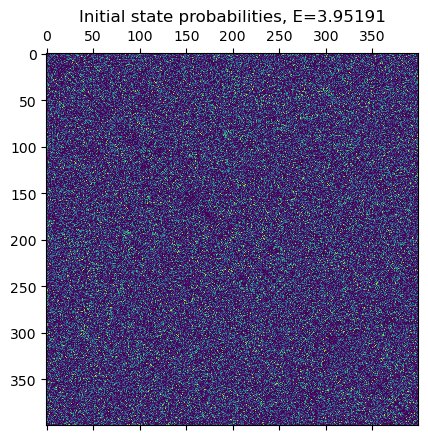

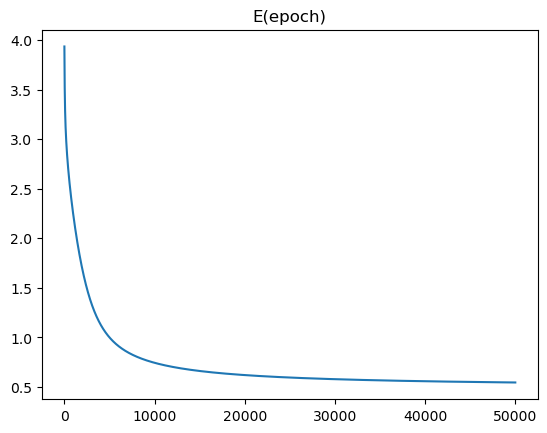

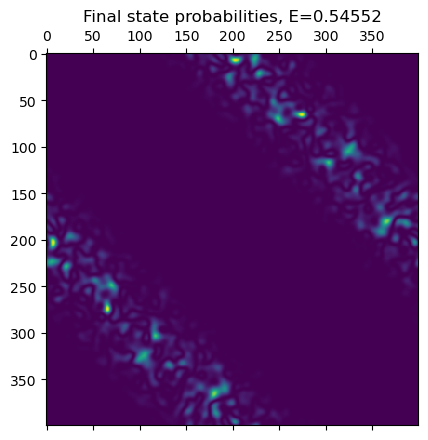

In [7]:
V = get_V(1, dx, N, eps)
psi = init_state(N)
energy = calc_energy(psi, V)

plt.matshow(psi * psi)
plt.title(f"Initial state probabilities, E={energy:.5f}")
plt.show()

animate_history(opt(psi))

### Large k

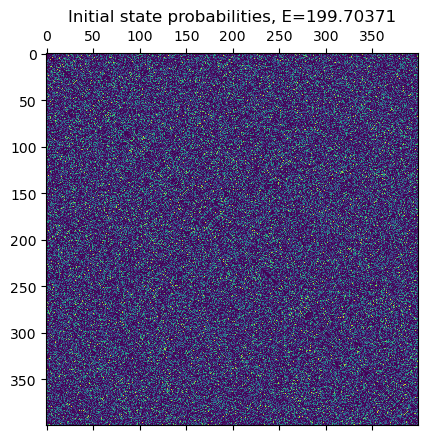

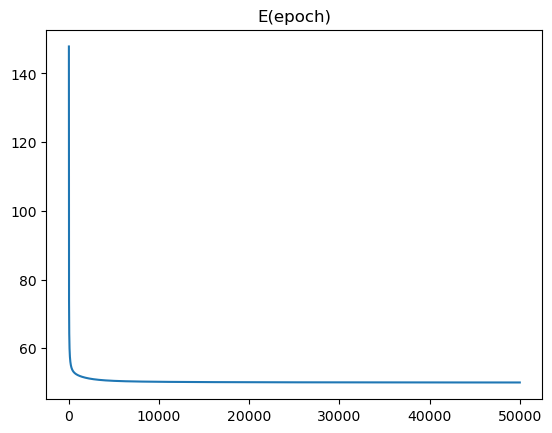

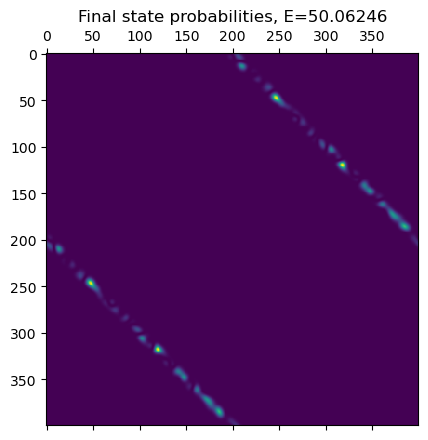

In [8]:
V = get_V(100, dx, N, eps)
psi = init_state(N)
energy = calc_energy(psi, V)

plt.matshow(psi * psi)
plt.title(f"Initial state probabilities, E={energy:.5f}")
plt.show()

animate_history(opt(psi))

experiments do support the theoretical considerations, but at the same time we get clusters that are very slow to merge, which might be related to the fact that we assume the wavefunction to be real

## f)

Slater determinant can't represent the ground state "faithfully", since it doesn't take the interaction into account, failing to describe the peak at $x_2=x_1+\pi$.

## g)

Memory complexity will be proportional to the size of the state vector, which is of size $M^N$.

Assuming $M=2^{10}$:

- N=2: 1 MB
- N=10: ~$10^{18}$ TB
- N=100: ~$10^{288}$ TB